# Training ML Models on the IDS2017 Dataset with Hyperparameter Optimization

After experimenting various models based on random trees and random forests, with multiple resampling techniques for handling imbalance, the SMOTE method increased accuracy of detection for underrepresentend attacks. In this notebook, random forests, random trees and xgboost with SMOTE for generating synthetic samples are trained with hyperpamater optimization.

In [1]:
from utils_ids2017 import load_ids2017, feature_selection
from sklearn.model_selection import train_test_split, GridSearchCV
import os
import pandas as pd
import numpy as np

attack_labels = {
    0: 'BENIGN',
    7: 'FTP-Patator',
    11: 'SSH-Patator',
    6: 'DoS slowloris',
    5: 'DoS Slowhttptest',
    4: 'DoS Hulk',
    3: 'DoS GoldenEye',
    8: 'Heartbleed',
    12: 'Web Attack - Brute Force',
    14: 'Web Attack - XSS',
    13: 'Web Attack - Sql Injection',
    9: 'Infiltration',
    1: 'Bot',
    10: 'PortScan',
    2: 'DDoS'
}

## Load and Prepare Dataset


In [2]:
df = load_ids2017()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 96 columns):
 #   Column                       Dtype   
---  ------                       -----   
 0   destination_port             int64   
 1   protocol                     int64   
 2   flow_duration                int64   
 3   total_fwd_packets            int64   
 4   total_backward_packets       int64   
 5   total_length_of_fwd_packets  float64 
 6   total_length_of_bwd_packets  float64 
 7   fwd_packet_length_max        float64 
 8   fwd_packet_length_min        float64 
 9   fwd_packet_length_mean       float64 
 10  fwd_packet_length_std        float64 
 11  bwd_packet_length_max        float64 
 12  bwd_packet_length_min        float64 
 13  bwd_packet_length_mean       float64 
 14  bwd_packet_length_std        float64 
 15  flow_bytes_s                 float64 
 16  flow_packets_s               float64 
 17  flow_iat_mean                float64 
 18  flow_iat_std          

In [3]:
X = df.iloc[:, 0:79]
Y = df.iloc[:, 79:]
X.info()
Y.info()
print(Y.label.value_counts())

<class 'pandas.core.frame.DataFrame'>
Index: 2827876 entries, 0 to 2830742
Data columns (total 79 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   destination_port             int64  
 1   protocol                     int64  
 2   flow_duration                int64  
 3   total_fwd_packets            int64  
 4   total_backward_packets       int64  
 5   total_length_of_fwd_packets  float64
 6   total_length_of_bwd_packets  float64
 7   fwd_packet_length_max        float64
 8   fwd_packet_length_min        float64
 9   fwd_packet_length_mean       float64
 10  fwd_packet_length_std        float64
 11  bwd_packet_length_max        float64
 12  bwd_packet_length_min        float64
 13  bwd_packet_length_mean       float64
 14  bwd_packet_length_std        float64
 15  flow_bytes_s                 float64
 16  flow_packets_s               float64
 17  flow_iat_mean                float64
 18  flow_iat_std                 float64
 19  flow_

## Feature Selection

In [4]:
X = feature_selection(X, Y)

                        Feature  Information Gain
1                 flow_duration          0.226763
10               flow_packets_s          0.217080
3   total_length_of_fwd_packets          0.211238
11                flow_iat_mean          0.209472
9                  flow_bytes_s          0.203995
23                bwd_packets_s          0.201717
4         fwd_packet_length_max          0.186534
31       init_win_bytes_forward          0.186414
6        fwd_packet_length_mean          0.181100
12                 flow_iat_std          0.174371
7         bwd_packet_length_max          0.164060
32      init_win_bytes_backward          0.151304
18                  bwd_iat_max          0.148585
15                bwd_iat_total          0.148202
16                 bwd_iat_mean          0.144759
21            fwd_header_length          0.142627
5         fwd_packet_length_min          0.114397
24            min_packet_length          0.109817
2             total_fwd_packets          0.104188


## Split dataset

The dataset is split into a training set and a testing set with a ratio of 0.8/0.2. The dataset is stratified according to the label to have an equal representation of all classes in the 2 subsets.

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y.label_code)

In [6]:
Y_train.label.value_counts()

label
BENIGN                        1817055
DoS Hulk                       184099
PortScan                       127043
DDoS                           102420
DoS GoldenEye                    8234
FTP-Patator                      6348
SSH-Patator                      4717
DoS slowloris                    4637
DoS Slowhttptest                 4399
Bot                              1565
Web Attack - Brute Force         1206
Web Attack - XSS                  522
Infiltration                       29
Web Attack - Sql Injection         17
Heartbleed                          9
Name: count, dtype: int64

In [7]:
Y_test.label.value_counts()

label
BENIGN                        454265
DoS Hulk                       46025
PortScan                       31761
DDoS                           25605
DoS GoldenEye                   2059
FTP-Patator                     1587
SSH-Patator                     1180
DoS slowloris                   1159
DoS Slowhttptest                1100
Bot                              391
Web Attack - Brute Force         301
Web Attack - XSS                 130
Infiltration                       7
Web Attack - Sql Injection         4
Heartbleed                         2
Name: count, dtype: int64

Statistics about the training set

In [8]:
benign_percentage = len(Y_train.label[Y_train["label"]=="BENIGN"])/len(Y_train)
print('Percentage of benign samples: %.4f' % benign_percentage)
print(Y_train.is_attack.value_counts())

Percentage of benign samples: 0.8032
is_attack
0    1817055
1     445245
Name: count, dtype: int64


## Helper functions

In [9]:
import joblib

def save_model(model, model_name):
    file_path = f'ML_models_ids/{model_name}.pkl'
    joblib.dump(model, file_path)
    print(f'Model saved to {file_path}')

def load_model(model_name):
    file_path = f'ML_models_ids/{model_name}.pkl'
    model = joblib.load(file_path)
    print(f'Model loaded from {file_path}')
    return model

os.makedirs('ML_models_ids', exist_ok=True)

In [10]:
from notebook_utils import plot_confusion_matrix, metrics_report, calculate_metrics_by_label, test_metrics, plot_overall_accuracy

## SMOTE Resampling

In [11]:
from imblearn.over_sampling import SMOTE

def resample_dataset(X, Y, min_samples, attack_labels):
    Y = Y.drop(columns=['label'])
    combined = pd.concat([X, Y], axis=1)
    counts = Y['label_code'].value_counts()
    samples_number = {i: max(counts[i], min_samples) for i in np.unique(Y['label_code'])}
    combined_array = combined.values
    y_array = Y['label_code'].values
    resampler = SMOTE(random_state=42, sampling_strategy=samples_number)
    resampled_array, y_resampled = resampler.fit_resample(combined_array, y_array)
    X_resampled = resampled_array[:, :-Y.shape[1]]
    Y_resampled = resampled_array[:, -Y.shape[1]:]
    X_resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
    Y_resampled_df = pd.DataFrame(Y_resampled, columns=Y.columns)
    Y_resampled_df['label'] = Y_resampled_df['label_code'].map(attack_labels)
    Y_resampled_df['label'] = Y_resampled_df['label'].astype('category')
    return X_resampled_df, Y_resampled_df

X_smote_train, Y_smote_train = resample_dataset(X_train, Y_train, 100000, attack_labels)


In [12]:
Y_smote_train.label.value_counts()

label
BENIGN                        1817055
DoS Hulk                       184099
PortScan                       127043
DDoS                           102420
Bot                            100000
DoS GoldenEye                  100000
DoS Slowhttptest               100000
DoS slowloris                  100000
FTP-Patator                    100000
Heartbleed                     100000
Infiltration                   100000
SSH-Patator                    100000
Web Attack - Brute Force       100000
Web Attack - Sql Injection     100000
Web Attack - XSS               100000
Name: count, dtype: int64

In [13]:
from sklearn.preprocessing import StandardScaler

scaler_smote = StandardScaler()
scaler_smote.fit(X_smote_train)

StandardScaler()

## Random Forest Optimized

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 21.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 34.6min finished


Best Hyperparameters for RandomForest: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 30, 'bootstrap': False}
Random Forest with SMOTE Test Set Performance


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    4.4s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    7.1s finished


Classification Report (Test Random Forest (SMOTE)):
              precision    recall  f1-score   support

           0     0.9998    0.9971    0.9984    454265
           1     0.9883    0.9992    0.9937    111311

    accuracy                         0.9975    565576
   macro avg     0.9940    0.9981    0.9961    565576
weighted avg     0.9975    0.9975    0.9975    565576

Accuracy: 0.9974981258044896
Precision: 0.9975231414589576
Recall: 0.9974981258044896
F1 Score: 0.9975032909411776
AUC: 0.9981237624942402


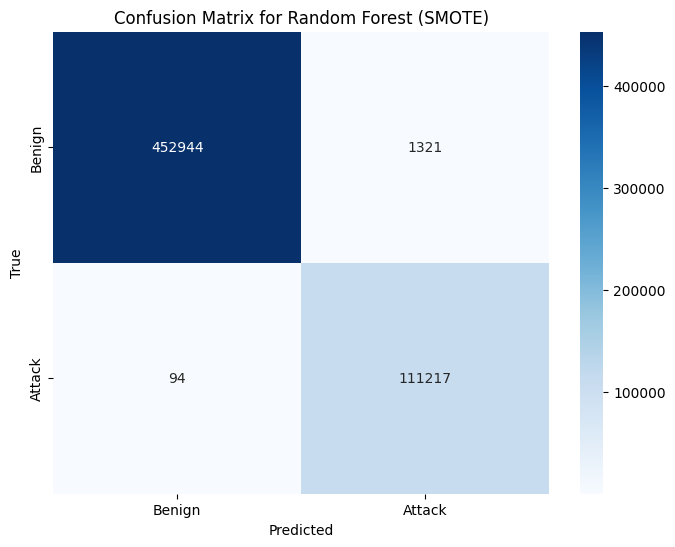

Metrics by Label (SMOTE):
                         Label  Accuracy Method
0                       BENIGN  0.997092  SMOTE
1                     DoS Hulk  0.999174  SMOTE
2                     PortScan  0.999937  SMOTE
3                         DDoS  0.999414  SMOTE
4                DoS GoldenEye  0.998543  SMOTE
5                  SSH-Patator  0.997458  SMOTE
6             DoS Slowhttptest  1.000000  SMOTE
7                DoS slowloris  0.997412  SMOTE
8                  FTP-Patator  0.999370  SMOTE
9     Web Attack - Brute Force  0.993355  SMOTE
10                         Bot  0.951407  SMOTE
11            Web Attack - XSS  0.984615  SMOTE
12  Web Attack - Sql Injection  0.750000  SMOTE
13                Infiltration  0.285714  SMOTE
14                  Heartbleed  1.000000  SMOTE
Model saved to ML_models_ids/RandomForest_SMOTE.pkl


In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

metrics = {}

# Define the parameter grid for GridSearchCV
rf_param_grid  = {
    'n_estimators': [100, 200, 300],
    'max_features': [None, 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Create a RandomForestClassifier instance
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1, verbose=1)

# Create a RandomizedSearchCV instance
rf_random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=rf_param_grid, 
                                      n_iter=10, cv=2, verbose=2, n_jobs=-1, random_state=42)

# Fit the RandomizedSearchCV model
rf_random_search.fit(scaler_smote.transform(X_smote_train), Y_smote_train.is_attack)

# Get the best estimator
best_rf_model = rf_random_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters for RandomForest:", rf_random_search.best_params_)

# Predict and evaluate on the test set using the best model
metrics["RandomForest"] = test_metrics("Random Forest", best_rf_model, "SMOTE", scaler_smote, X_test, Y_test)

# Save the best RandomForest model
save_model(best_rf_model, "RandomForest_SMOTE")

## XGBoost Optimized

Fitting 2 folds for each of 10 candidates, totalling 20 fits
Best Hyperparameters for XGBoost: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 0.2, 'colsample_bytree': 0.8}
XGBoost with SMOTE Test Set Performance
Classification Report (Test XGBoost (SMOTE)):
              precision    recall  f1-score   support

           0     0.9999    0.9982    0.9990    454265
           1     0.9928    0.9994    0.9961    111311

    accuracy                         0.9985    565576
   macro avg     0.9963    0.9988    0.9976    565576
weighted avg     0.9985    0.9985    0.9985    565576

Accuracy: 0.9984599770853078
Precision: 0.9984692923080261
Recall: 0.9984599770853078
F1 Score: 0.9984619133863055
AUC: 0.9988276603724627


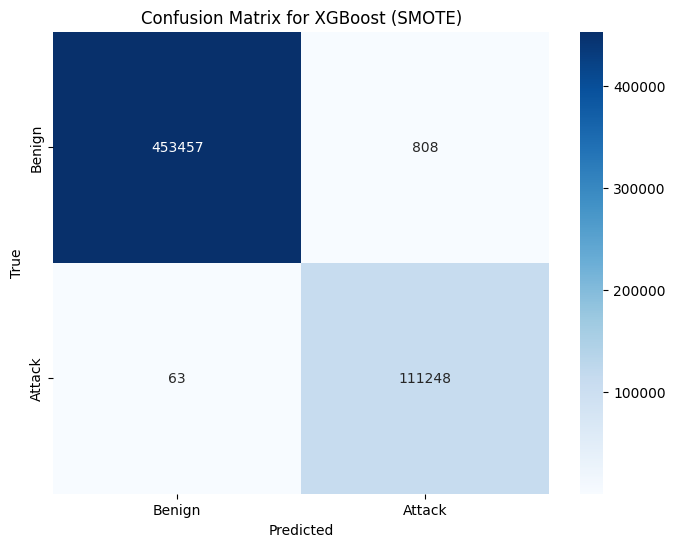

Metrics by Label (SMOTE):
                         Label  Accuracy Method
0                       BENIGN  0.998221  SMOTE
1                     DoS Hulk  0.999479  SMOTE
2                     PortScan  0.999937  SMOTE
3                         DDoS  0.999531  SMOTE
4                DoS GoldenEye  0.999514  SMOTE
5                  SSH-Patator  0.999153  SMOTE
6             DoS Slowhttptest  0.999091  SMOTE
7                DoS slowloris  0.999137  SMOTE
8                  FTP-Patator  1.000000  SMOTE
9     Web Attack - Brute Force  0.993355  SMOTE
10                         Bot  0.969309  SMOTE
11            Web Attack - XSS  0.976923  SMOTE
12  Web Attack - Sql Injection  1.000000  SMOTE
13                Infiltration  0.428571  SMOTE
14                  Heartbleed  1.000000  SMOTE
Model saved to ML_models_ids/XGBoost_SMOTE.pkl


In [15]:
from xgboost import XGBClassifier

# Define the parameter grid for GridSearchCV
xgb_param_grid  = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2]
}

# Create an XGBClassifier instance
xgb_model = XGBClassifier(random_state=42, n_jobs=-1, verbosity=1)

# Create a RandomizedSearchCV instance
xgb_random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=xgb_param_grid, 
                                       n_iter=10, cv=2, verbose=2, n_jobs=-1, random_state=42)

# Fit the RandomizedSearchCV model
xgb_random_search.fit(scaler_smote.transform(X_smote_train), Y_smote_train.is_attack)

# Get the best estimator
best_xgb_model = xgb_random_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters for XGBoost:", xgb_random_search.best_params_)

# Predict and evaluate on the test set using the best model
metrics["XGBoost"] = test_metrics("XGBoost", best_xgb_model, "SMOTE", scaler_smote, X_test, Y_test)

# Save the best XGBoost model
save_model(best_xgb_model, "XGBoost_SMOTE")

## Decision Tree Optimized

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best Hyperparameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 5}
Decision Tree with SMOTE Test Set Performance
Classification Report (Test Decision Tree (SMOTE)):
              precision    recall  f1-score   support

           0     0.9997    0.9973    0.9985    454265
           1     0.9891    0.9989    0.9940    111311

    accuracy                         0.9976    565576
   macro avg     0.9944    0.9981    0.9963    565576
weighted avg     0.9976    0.9976    0.9976    565576

Accuracy: 0.997621893432536
Precision: 0.9976426662395744
Recall: 0.997621893432536
F1 Score: 0.9976263182846953
AUC: 0.9981126377946868


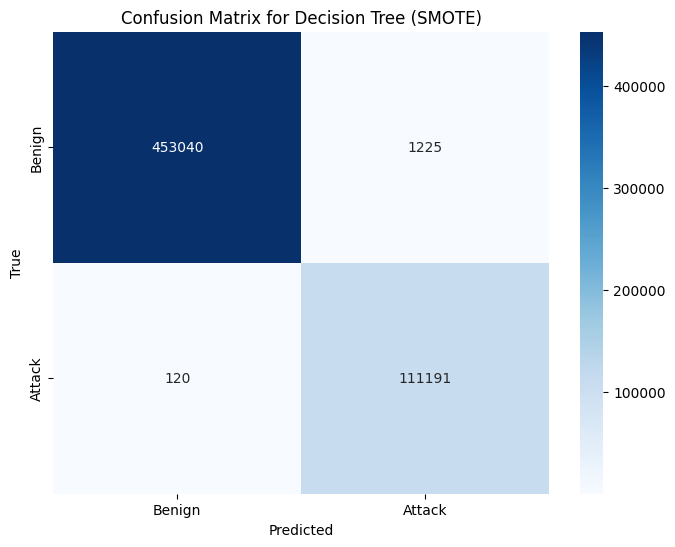

Metrics by Label (SMOTE):
                         Label  Accuracy Method
0                       BENIGN  0.997303  SMOTE
1                     DoS Hulk  0.999196  SMOTE
2                     PortScan  0.999906  SMOTE
3                         DDoS  0.999609  SMOTE
4                DoS GoldenEye  0.995629  SMOTE
5                  SSH-Patator  0.994915  SMOTE
6             DoS Slowhttptest  0.990909  SMOTE
7                DoS slowloris  0.997412  SMOTE
8                  FTP-Patator  1.000000  SMOTE
9     Web Attack - Brute Force  0.990033  SMOTE
10                         Bot  0.925831  SMOTE
11            Web Attack - XSS  0.969231  SMOTE
12  Web Attack - Sql Injection  0.750000  SMOTE
13                Infiltration  0.285714  SMOTE
14                  Heartbleed  1.000000  SMOTE
Model saved to ML_models_ids/DecisionTree_SMOTE.pkl


In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for GridSearchCV
dt_param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Create a DecisionTreeClassifier instance
dt_model = DecisionTreeClassifier(random_state=42)

# Create a GridSearchCV instance
dt_grid_search = GridSearchCV(estimator=dt_model, param_grid=dt_param_grid, 
                              cv=3, verbose=2, n_jobs=-1)

# Fit the GridSearchCV model
dt_grid_search.fit(scaler_smote.transform(X_smote_train), Y_smote_train.is_attack)

# Get the best estimator
best_dt_model = dt_grid_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters for Decision Tree:", dt_grid_search.best_params_)

# Predict and evaluate on the test set using the best model
metrics["dt_smote"] = test_metrics("Decision Tree", best_dt_model, "SMOTE", scaler_smote, X_test, Y_test)

# Save the best Decision Tree model
save_model(best_dt_model, "DecisionTree_SMOTE")


In [17]:
print(metrics)

{'RandomForest': ({'accuracy': 0.9974981258044896, 'precision': 0.9975231414589576, 'recall': 0.9974981258044896, 'f1': 0.9975032909411776, 'auc': 0.9981237624942402},                          Label  Accuracy Method
0                       BENIGN  0.997092  SMOTE
1                     DoS Hulk  0.999174  SMOTE
2                     PortScan  0.999937  SMOTE
3                         DDoS  0.999414  SMOTE
4                DoS GoldenEye  0.998543  SMOTE
5                  SSH-Patator  0.997458  SMOTE
6             DoS Slowhttptest  1.000000  SMOTE
7                DoS slowloris  0.997412  SMOTE
8                  FTP-Patator  0.999370  SMOTE
9     Web Attack - Brute Force  0.993355  SMOTE
10                         Bot  0.951407  SMOTE
11            Web Attack - XSS  0.984615  SMOTE
12  Web Attack - Sql Injection  0.750000  SMOTE
13                Infiltration  0.285714  SMOTE
14                  Heartbleed  1.000000  SMOTE), 'XGBoost': ({'accuracy': 0.9984599770853078, 'precision': 0.99

In [24]:
import matplotlib.pyplot as plt
def plot_metrics_bar_chart(metrics):
    # Extract the model names
    model_names = list(metrics.keys())
    
    # Initialize a dictionary to store the metrics
    metrics_data = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'auc': []
    }
    
    # Populate the dictionary with metrics from each model
    for model in model_names:
        metrics_data['accuracy'].append(metrics[model][0]['accuracy'])
        metrics_data['precision'].append(metrics[model][0]['precision'])
        metrics_data['recall'].append(metrics[model][0]['recall'])
        metrics_data['f1'].append(metrics[model][0]['f1'])
        metrics_data['auc'].append(metrics[model][0]['auc'])

    # Create a bar chart
    x = np.arange(len(model_names))  # the label locations
    width = 0.15  # the width of the bars

    fig, ax = plt.subplots(figsize=(14, 8))
    
    rects1 = ax.bar(x - 2*width, metrics_data['accuracy'], width, label='Accuracy')
    rects2 = ax.bar(x - width, metrics_data['precision'], width, label='Precision')
    rects3 = ax.bar(x, metrics_data['recall'], width, label='Recall')
    rects4 = ax.bar(x + width, metrics_data['f1'], width, label='F1 Score')
    rects5 = ax.bar(x + 2*width, metrics_data['auc'], width, label='AUC')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('Models')
    ax.set_ylabel('Scores')
    ax.set_title('Comparison of Metrics for Different Models')
    ax.set_xticks(x)
    ax.set_xticklabels(model_names, rotation=45)
    ax.set_ylim([0.99, 1.0])
    ax.legend()

    fig.tight_layout()

    plt.show()

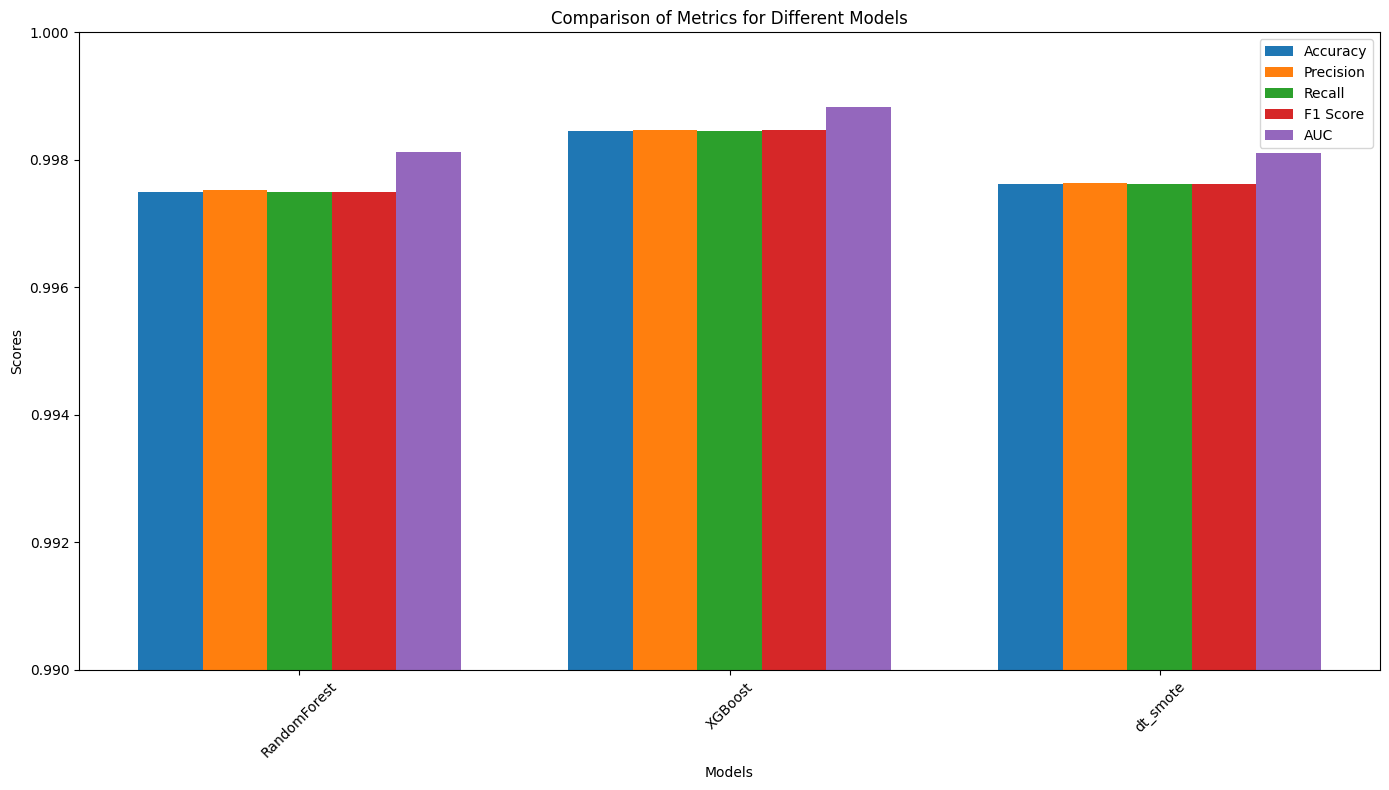

In [25]:
plot_metrics_bar_chart(metrics)